In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import torchsde
from torchdyn.core import NeuralODE
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid

from torchcfm.conditional_flow_matching import *
from torchcfm.models.unet import UNetModel

import netCDF4
from tqdm.notebook import tqdm
from tqdm.notebook import trange

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [2]:
era5_fp = '../data/cmip/6d54301da007a125ad83767ca9e617ca.nc'
era5 = netCDF4.Dataset(era5_fp)
# print(era5)

In [3]:
era5['t2m'].shape

(600, 721, 1440)

In [137]:
cesm_fp = '../data/cmip/ts_Amon_CESM2_historical_r1i1p1f1_gn_19500115-19991215.nc'
cesm = netCDF4.Dataset(cesm_fp)
# print(cesm) 

In [5]:
cesm['ts'].shape

(600, 192, 288)

In [6]:
downsample = nn.Upsample(size = (32, 64), mode = 'bicubic')

In [7]:
y = np.array(era5['t2m'])
y = y - 273.15
y = torch.tensor(y)[:,None]
y = downsample(y)

ytrain = y[0:500]
ytest = y[500:]

In [8]:
x = np.array(cesm['ts'])
x = x - 273.15
x = np.flip(x, axis = 1)
x = torch.tensor(x.copy())[:,None]
x = downsample(x)

xtrain = x[0:500]
xtest = x[500:]

In [9]:
### mutual info testing
import jax
import jax.numpy as jnp
from jax import vmap, grad, jit, random

def fpca(x):
    x = x.reshape(x.shape[0], -1)
    w = jnp.ones(x.shape[0])/x.shape[0]
    mu = x.T @ w
    x = (x - mu[None])
    sig = x.T @ jnp.diag(w) @ x
    vals, comps = jnp.linalg.eigh(sig)
    comps = jnp.flip(comps, axis = 1)
    state = [mu, jnp.flip(vals), comps]
    return state
fpca = jit(fpca)

def transform_fpca(x, state):
    x = x.reshape(x.shape[0], -1)
    mu, vals, comps = state
    x = (x - mu[None])
    return x @ comps / jnp.sqrt(vals)[None,]
transform_fpca = jit(transform_fpca)

def mutual_info(x, y):
    z = jnp.concat([x, y], axis = 1)
    
    sig_x = jnp.cov(x.T)
    sig_y = jnp.cov(y.T)
    sig_z = jnp.cov(z.T)

    det_x = jnp.linalg.det(sig_x)
    det_y = jnp.linalg.det(sig_y)
    det_z = jnp.linalg.det(sig_z)

    return 0.5 * jnp.log((det_x * det_y) / det_z)
mutual_info = jit(mutual_info)

def mutual_info1d(x, y):
    z = jnp.concat([x, y], axis = 1)
    
    sig_x = jnp.cov(x.T)
    sig_y = jnp.cov(y.T)
    sig_z = jnp.cov(z.T)

    det_x = sig_x
    det_y = sig_y
    det_z = jnp.linalg.det(sig_z)

    return 0.5 * jnp.log((det_x * det_y) / det_z)
mutual_info1d = jit(mutual_info1d)

In [10]:
x0 = jnp.array(np.array(x))
x0 = jnp.mean(x0, axis = (1, 2, 3))[:,None]

x_mu = jnp.array([jnp.mean(x0[i::12]) for i in range(12)])
x0 = x0 - jnp.tile(x_mu, 50)[:,None]

y0 = jnp.array(np.array(y))
y0 = jnp.mean(y0, axis = (1, 2, 3))[:,None]

y_mu = jnp.array([jnp.mean(y0[i::12]) for i in range(12)])
y0 = y0 - jnp.tile(y_mu, 50)[:,None]

# plt.plot(x0)
# plt.plot(y0)
mutual_info1d(x0, y0)

Array(0.09876055, dtype=float32)

In [147]:
n1 = x.shape[0]
n2 = 400
rng = random.key(0)
rng, key1, key2 = random.split(rng, 3)

x0 = jnp.array(np.array(x))
y0 = jnp.array(np.array(y))

x_mu = jnp.array([jnp.mean(x0[i::12], axis = 0) for i in range(12)])
y_mu = jnp.array([jnp.mean(y0[i::12], axis = 0) for i in range(12)])

x1 = x0 - jnp.tile(x_mu, (50, 1, 1, 1))
y1 = y0 - jnp.tile(y_mu, (50, 1, 1, 1))

state = fpca(jnp.concat([x1[0:n2], y1[0:n2]], axis = 0))

d = 50
state[1] = state[1][:d]
state[2] = state[2][:,:d]

x2 = transform_fpca(x1[n2:], state)
y2 = transform_fpca(y1[n2:], state)
mi = mutual_info(x2, y2)
mi

Array(10.282184, dtype=float32)

In [148]:
rng, key1, key2 = random.split(rng, 3)
z_noise = jnp.concat([x2, y2], axis = 0)
z_noise = random.permutation(key1, z_noise)
x_noise = z_noise[(n1-n2):]
y_noise = z_noise[:(n1-n2)]
mutual_info(x_noise, y_noise)

Array(8.511881, dtype=float32)

In [149]:
mi_perm = np.ones(1000)

for i in trange(1000):
    rng, key1 = random.split(rng)
    z_noise = jnp.concat([x2, y2], axis = 0)
    z_noise = random.permutation(key1, z_noise)
    x_noise = z_noise[(n1-n2):]
    y_noise = z_noise[:(n1-n2)]
    mi_perm[i] = mutual_info(x_noise, y_noise)

  0%|          | 0/1000 [00:00<?, ?it/s]

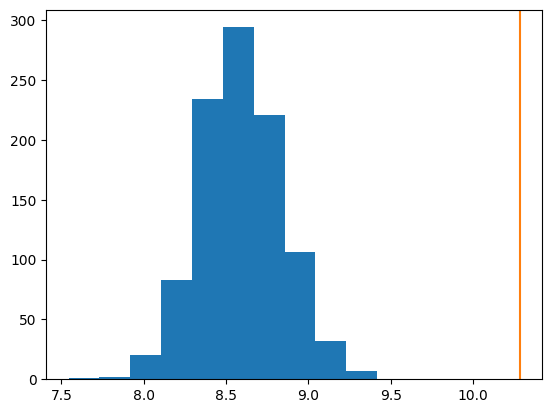

In [150]:
plt.hist(mi_perm)
plt.axvline(mi, c = 'C1')

In [173]:
mi_corr = np.ones(1000)
sig = 0.5
for i in trange(1000):
    rng, key1, key2 = random.split(rng, 3)
    mi_corr[i] = mutual_info(x2 + jnp.std(x2, axis = 0)[None,]*random.normal(key1, x2.shape), 
                             y2 + jnp.std(y2, axis = 0)[None,]*random.normal(key2, y2.shape))

  0%|          | 0/1000 [00:00<?, ?it/s]

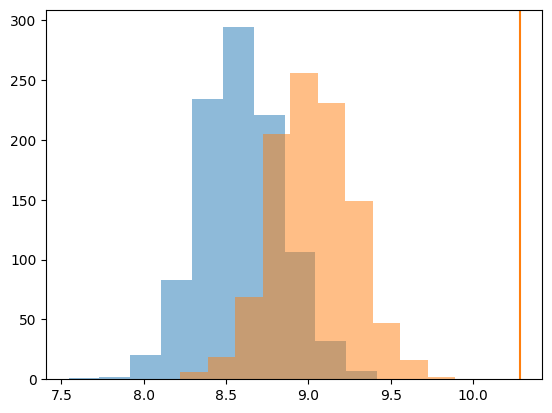

In [174]:
plt.hist(mi_perm, alpha = 0.5)
plt.hist(mi_corr, alpha = 0.5)
plt.axvline(mi, c = 'C1')

In [47]:
n, d = x2.shape

In [48]:
rng, key1, key2 = random.split(rng, 3)

x_noise = random.normal(key1, (n, d))
y_noise = random.normal(key2, (n, d))
mutual_info(x_noise, y_noise)

Array(5.073471, dtype=float32)

In [177]:
train_data = TensorDataset(xtrain, ytrain)
train_loader = DataLoader(train_data, batch_size=16, shuffle=False)

In [17]:
sigma = 0.0
model = UNetModel(dim=(1, 28, 28), 
                  num_channels=32, 
                  num_res_blocks=1).to(device)
optimizer = torch.optim.Adam(model.parameters())
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)
node = NeuralODE(model, solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

In [18]:
n_epochs = 20

for epoch in trange(n_epochs):
    for i, data in tqdm(enumerate(train_loader), leave = False):
        x1 = data[1].to(device)
        x0 = data[0].to(device)
        x0 += 2 * torch.std(x0) * torch.randn_like(x0)
        t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
        vt = model(t, xt)
        loss = torch.mean((vt - ut)**2)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

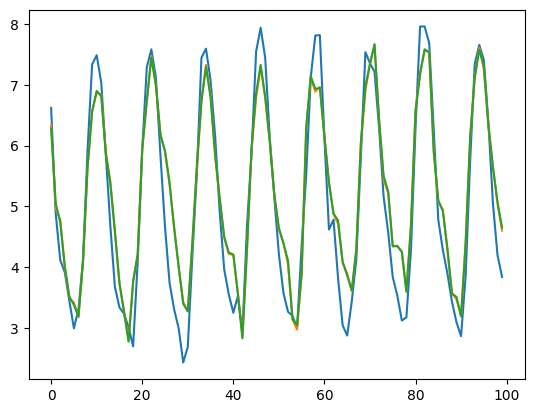

In [27]:
# xtest = x[200:250]
# ytest = y[200:250]

with torch.no_grad():
    yhat1 = node.trajectory(
        xtest.to(device) + torch.randn_like(xtest).to(device),
        t_span=torch.linspace(0, 1, 2, device=device),
    )
yhat1 = yhat1[-1].squeeze()

with torch.no_grad():
    yhat2 = node.trajectory(
        xtest.to(device) + torch.randn_like(xtest).to(device),
        t_span=torch.linspace(0, 1, 2, device=device),
    )
yhat2 = yhat2[-1].squeeze()

plt.plot(torch.mean(ytest, axis = (1, 2, 3)))
plt.plot(torch.mean(yhat1.cpu(), axis = (1, 2)))
plt.plot(torch.mean(yhat2.cpu(), axis = (1, 2)))

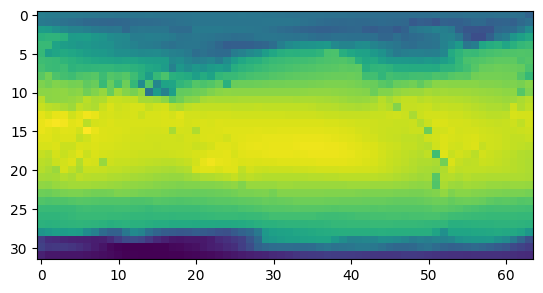

In [28]:
plt.imshow(yhat2[6].cpu())

In [99]:
class ConvEncoder(nn.Module):
    def __init__(self, in_channels=12, feature_dims=[16, 32, 64]):
        super(ConvEncoder, self).__init__()
        layers = []
        current_channels = in_channels
        for out_channels in feature_dims:
            layers += [
                nn.Conv2d(current_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2)
            ]
            current_channels = out_channels
        self.encoder = nn.Sequential(*layers)

    def forward(self, x):
        return self.encoder(x)


class ConvDecoder(nn.Module):
    def __init__(self, out_channels=12, feature_dims=[64, 32, 16]):
        super(ConvDecoder, self).__init__()
        layers = []
        current_channels = feature_dims[0]
        for out_channels_ in feature_dims[1:]:
            layers += [
                nn.ConvTranspose2d(current_channels, out_channels_, kernel_size=2, stride=2),
                nn.ReLU(inplace=True)
            ]
            current_channels = out_channels_
        # Final layer to recover original channel count
        layers += [nn.ConvTranspose2d(current_channels, out_channels_, kernel_size=2, stride=2)]
        layers += [nn.Conv2d(current_channels, out_channels, kernel_size=3, padding=1)]
        self.decoder = nn.Sequential(*layers)

    def forward(self, x):
        return self.decoder(x)


# Full autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self, in_channels=3):
        super(ConvAutoencoder, self).__init__()
        self.encoder = ConvEncoder(in_channels=in_channels)
        self.decoder = ConvDecoder(out_channels=in_channels)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

In [100]:
downsample1 = nn.Upsample(size = (2**7, 2**8), mode = 'bicubic')
downsample2 = nn.Upsample(size = (32, 64), mode = 'bicubic')

In [27]:
# torch.tensor(np.array([torch.mean(x[i::12], axis = 0) for i in range(12)]))

In [160]:
x = np.array(cesm['ts'])
x = x - 273.15
x = np.flip(x, axis = 1)
x = torch.tensor(x.copy())[:,None]
x_mu = torch.tensor(np.array([torch.mean(x[i::12], axis = 0) for i in range(12)]))
x = x - torch.tile(x_mu, (50, 1, 1, 1))

x = x.reshape(-1, 12, 192, 288)
x = downsample(x)

In [162]:
train_data = TensorDataset(x)
train_loader = DataLoader(train_data, batch_size=16, shuffle=False)

In [163]:
auto_enc = ConvAutoencoder(in_channels=12)
auto_enc.to(device)
optim = torch.optim.Adam(auto_enc.parameters(), lr = 1e-3)
trace = []
n_epochs = 1000
for epoch in trange(n_epochs):
    for i, data in tqdm(enumerate(train_loader), leave = False):
        x1 = data[0].to(device)
        xhat = auto_enc(x1)
        loss = nn.MSELoss()(x1, xhat)
        loss.backward()
        trace.append(loss.detach().cpu())
        optim.step()
        optim.zero_grad()

  0%|          | 0/1000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

KeyboardInterrupt: 

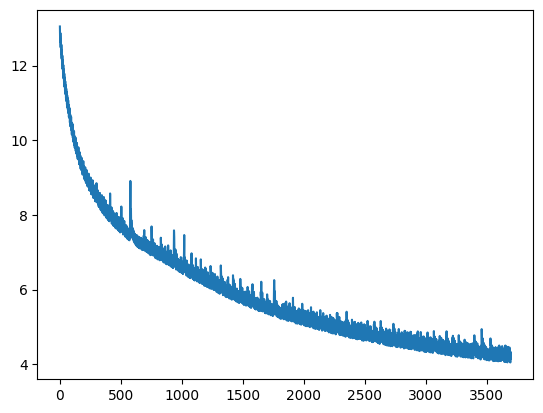

In [111]:
plt.plot(trace[300:])

In [112]:
with torch.no_grad():
    z = auto_enc.encode(x.to(device))
z.shape

torch.Size([50, 64, 16, 32])

In [10]:
downsample = nn.Upsample(size = (32, 64), mode = 'bicubic')
upsample = nn.Upsample(size = (192, 288), mode = 'bicubic')

In [11]:
x = np.array(cesm['ts'])
x = x - 273.15
x = np.flip(x, axis = 1)
x = torch.tensor(x.copy())[:,None]
x_mu = torch.tensor(np.array([torch.mean(x[i::12], axis = 0) for i in range(12)]))
x = x - torch.tile(x_mu, (50, 1, 1, 1))

x = x.reshape(-1, 12, 192, 288)
x = downsample(x)

In [12]:
train_data = TensorDataset(x)
train_loader = DataLoader(train_data, batch_size=16, shuffle=False)

In [22]:
sigma = 0.0
model = UNetModel(dim=(12, 32, 64),
                  num_channels=64, 
                  num_res_blocks=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)
node = NeuralODE(model, solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

In [23]:
n_epochs = 200
for epoch in trange(n_epochs):
    for i, data in tqdm(enumerate(train_loader), leave = False):
        x1 = data[0].to(device)
        x0 = torch.randn_like(x1).to(device)
        t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
        vt = model(t, xt)
        loss = torch.mean((vt - ut)**2)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

  0%|          | 0/200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [24]:
with torch.no_grad():
    yhat = node.trajectory(
        torch.randn_like(x).to(device),
        t_span=torch.linspace(0, 1, 2, device=device),
    )
yhat = yhat[-1].squeeze().detach().cpu()
yhat1 = upsample(yhat)

with torch.no_grad():
    yhat = node.trajectory(
        torch.randn_like(x).to(device),
        t_span=torch.linspace(0, 1, 2, device=device),
    )
yhat = yhat[-1].squeeze().detach().cpu()
yhat2 = upsample(yhat)

with torch.no_grad():
    yhat = node.trajectory(
        torch.randn_like(x).to(device),
        t_span=torch.linspace(0, 1, 2, device=device),
    )
yhat = yhat[-1].squeeze().detach().cpu()
yhat3 = upsample(yhat)

In [25]:
yhat1 = yhat1.reshape(-1, 192, 288)
yhat2 = yhat2.reshape(-1, 192, 288)
yhat3 = yhat3.reshape(-1, 192, 288)
y = upsample(x).reshape(-1, 192, 288)

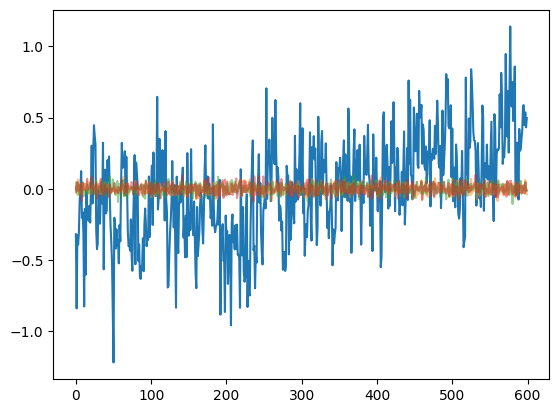

In [26]:
plt.plot(torch.mean(y, axis = (1, 2)))
plt.plot(torch.mean(yhat1, axis = (1, 2)), alpha = 0.5)
plt.plot(torch.mean(yhat2, axis = (1, 2)), alpha = 0.5)
plt.plot(torch.mean(yhat3, axis = (1, 2)), alpha = 0.5)

In [ ]:
era5_fp = '../data/cmip/6d54301da007a125ad83767ca9e617ca.nc'
era5 = netCDF4.Dataset(era5_fp)
cesm_fp = '../data/cmip/ts_Amon_CESM2_historical_r1i1p1f1_gn_19500115-19991215.nc'
cesm = netCDF4.Dataset(cesm_fp)

In [ ]:
downsample = nn.Upsample(size = (32, 64), mode = 'bicubic')
upsample = nn.Upsample(size = (192, 288), mode = 'bicubic')

In [ ]:
x = np.array(cesm['ts'])
x = x - 273.15
x = np.flip(x, axis = 1)
x = torch.tensor(x.copy())[:,None]
x_mu = torch.tensor(np.array([torch.mean(x[i::12], axis = 0) for i in range(12)]))
x = x - torch.tile(x_mu, (50, 1, 1, 1))

x = x.reshape(-1, 12, 192, 288)
x = downsample(x)


y = np.array(era5['t2m'])
y = y - 273.15
y = np.flip(y, axis = 1)
y = torch.tensor(y.copy())[:,None]
y_mu = torch.tensor(np.array([torch.mean(y[i::12], axis = 0) for i in range(12)]))
y = y - torch.tile(y_mu, (50, 1, 1, 1))

y = y.reshape(-1, 12, 721, 1440)
y = downsample(y)

train_data = TensorDataset(x, y)
train_loader = DataLoader(train_data, batch_size=16, shuffle=False)

In [ ]:
sigma = 0.0
model = UNetModel(dim=(12, 32, 64),
                  num_channels=64, 
                  num_res_blocks=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)
node = NeuralODE(model, solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

In [ ]:
lam = 0.1
lam1, lam2 = np.sqrt(lam), np.sqrt(1-lam)
lam1, lam2 = lam1/(lam1+lam2), lam2/(lam1+lam2)

In [ ]:
n_epochs = 200
for epoch in trange(n_epochs):
    for i, data in tqdm(enumerate(train_loader), leave = False):
        x1 = data[1].to(device)
        x0 = lam1*data[0].to(device) + lam2*torch.randn_like(x1).to(device)
        t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
        vt = model(t, xt)
        loss = torch.mean((vt - ut)**2)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [ ]:
with torch.no_grad():
    yhat = node.trajectory(
        lam1*x.to(device) + lam2*torch.randn_like(x).to(device),
        t_span=torch.linspace(0, 1, 2, device=device),
    )
yhat = yhat[-1].squeeze().detach().cpu()
yhat1 = upsample(yhat)

with torch.no_grad():
    yhat = node.trajectory(
        lam1*x.to(device) + lam2*torch.randn_like(x).to(device),
        t_span=torch.linspace(0, 1, 2, device=device),
    )
yhat = yhat[-1].squeeze().detach().cpu()
yhat2 = upsample(yhat)

with torch.no_grad():
    yhat = node.trajectory(
        lam1*x.to(device) + lam2*torch.randn_like(x).to(device),
        t_span=torch.linspace(0, 1, 2, device=device),
    )
yhat = yhat[-1].squeeze().detach().cpu()
yhat3 = upsample(yhat)

In [ ]:
yhat1 = yhat1.reshape(-1, 192, 288)
yhat2 = yhat2.reshape(-1, 192, 288)
yhat3 = yhat3.reshape(-1, 192, 288)
y = upsample(x).reshape(-1, 192, 288)

In [ ]:
plt.plot(torch.mean(y, axis = (1, 2)))
plt.plot(torch.mean(yhat1, axis = (1, 2)), alpha = 0.5)
plt.plot(torch.mean(yhat2, axis = (1, 2)), alpha = 0.5)
plt.plot(torch.mean(yhat3, axis = (1, 2)), alpha = 0.5)
plt.show()